In [ ]:
!pip install geopandas/Shapely-1.8.2-cp39-cp39-win_amd64.whl
!pip install geopandas/GDAL-3.4.3-cp39-cp39-win_amd64.whl
!pip install geopandas/Fiona-1.8.21-cp39-cp39-win_amd64.whl
!pip install geopandas/geopandas-0.11.1-py3-none-any.whl
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install folium
!pip install fontawesomefree
!pip install pydeck
!pip install sklearn
!pip install imblearn
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install optuna
!pip install json
!pip install requests
!pip install lxml
!pip install tensorflow

In [93]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os
import time

# 지도 데이터 분석 라이브러리
import fiona
import geopandas

# 데이터 분석 라|이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import style
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import fontawesomefree as fa
import pydeck

# 데이터 분리
from sklearn.model_selection import train_test_split

# 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

# 데이터 샘플링
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# 머신러닝
import xgboost
import catboost
import lightgbm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import ensemble
import optuna

# 모델 스코어링
from sklearn.metrics import f1_score

# 딥러닝
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [2]:
# matplotlib 한글 지원 폰트 설정
plt.rc("font", family="Malgun Gothic")

In [3]:
# 데이터 불러오기

sejong = geopandas.read_file('./dataset/전처리후/세종/merge_11.geojson', encoding='utf-8')
sejong = sejong[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

daegu = geopandas.read_file('./dataset/전처리후/대구/merge_11.geojson', encoding='utf-8')
daegu = daegu[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

daejeon = geopandas.read_file('./dataset/전처리후/대전/merge_11.geojson', encoding='utf-8')
daejeon = daejeon[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

In [5]:
# 인구수 = 0 & 충전소 = 0 인 타일 제거

sejong_pp = sejong.drop(sejong[(sejong['인구수']==0) & (sejong['EV']==0)].index)
daegu_pp = daegu.drop(daegu[(daegu['인구수']==0) & (daegu['EV']==0)].index)
daejeon_pp = daejeon.drop(daejeon[(daejeon['인구수']==0) & (daejeon['EV']==0)].index)

print('세종시 데이터 수 :', len(sejong))
print('세종시 인구수=0, 충전소=0인 타일:', len(sejong_pp), end='\n\n')

print('대전시 데이터 수 :', len(daejeon))
print('대전시 인구수=0인, 충전소=0인 타일:', len(daejeon_pp), end='\n\n')

print('대구시 데이터 수 :', len(daegu))
print('대구시 인구수=0인, 충전소=0인 타일:', len(daegu_pp))

sejong_pp_idx = sejong_pp.index

sejong_pp.reset_index(drop=True, inplace=True)
daejeon_pp.reset_index(drop=True, inplace=True)
daegu_pp.reset_index(drop=True, inplace=True)

세종시 데이터 수 : 47396
세종시 인구수=0, 충전소=0인 타일: 3405

대전시 데이터 수 : 56081
대전시 인구수=0인, 충전소=0인 타일: 8626

대구시 데이터 수 : 90806
대구시 인구수=0인, 충전소=0인 타일: 13258


In [6]:
# 정규화

scaler = MinMaxScaler()
sejong_pp_minmax = scaler.fit_transform(sejong_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
sejong_pp_minmax = pd.DataFrame(sejong_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
sejong_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = sejong_pp_minmax

daegu_pp_minmax = scaler.fit_transform(daegu_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
daegu_pp_minmax = pd.DataFrame(daegu_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
daegu_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = daegu_pp_minmax

daejeon_pp_minmax = scaler.fit_transform(daejeon_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
daejeon_pp_minmax = pd.DataFrame(daejeon_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
daejeon_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = daejeon_pp_minmax

In [7]:
# 학습 / 검증 데이터 셋 분리

train_data = pd.concat([daegu_pp[daegu_pp.columns[3:-1]], daejeon_pp[daejeon_pp.columns[3:-1]]])
train_target = pd.concat([daegu_pp[daegu_pp.columns[-1]], daejeon_pp[daejeon_pp.columns[-1]]])

test_data = sejong_pp[sejong_pp.columns[3:-1]]
test_target = sejong_pp[sejong_pp.columns[-1]]

test_data.set_index(sejong_pp_idx, inplace=True)

In [8]:
### 랜덤언더샘플링
rus = RandomUnderSampler()
train_data_rus, train_target_rus = rus.fit_resample(train_data, train_target)

### 랜덤오버샘플링
ros = RandomOverSampler()
train_data_ros, train_target_ros = ros.fit_resample(train_data, train_target)

### 스모트오버샘플링
smote = SMOTE()
train_data_smote, train_target_smote = smote.fit_resample(train_data, train_target)

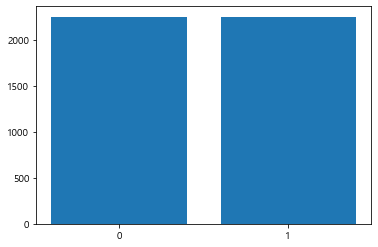

격자수:
 0    2251
1    2251
Name: EV, dtype: int64


비율 :
 0    0.5
1    0.5
Name: EV, dtype: float64


In [19]:
plt.bar(train_target_rus.unique(), train_target_rus.value_counts())
plt.xticks([0, 1])
plt.show()
print('격자수:\n', train_target_rus.value_counts())
print('\n')
print('비율 :\n', train_target_rus.value_counts()/len(train_target_rus))

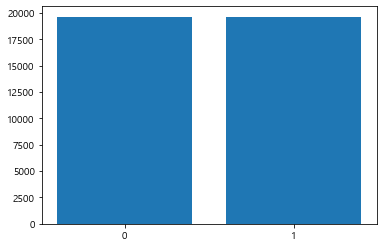

격자수:
 0    19633
1    19633
Name: EV, dtype: int64


비율 :
 0    0.5
1    0.5
Name: EV, dtype: float64


In [20]:
plt.bar(train_target_smote.unique(), train_target_smote.value_counts())
plt.xticks([0, 1])
plt.show()
print('격자수:\n', train_target_smote.value_counts())
print('\n')
print('비율 :\n', train_target_smote.value_counts()/len(train_target_smote))

## 하이퍼파라미터 튜닝 ( Optuna )

### RandomForest

In [23]:
def rf_optuna(train_data, train_target, test_data, test_target, threshold):
    def rf_objective(trial):
        
        params = {
                    'max_depth' : trial.suggest_int('max_depth', 1, 10),
                    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
                    'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                    "n_jobs": 4
            }

        clf = ensemble.RandomForestClassifier(**params, verbose=0)
        clf.fit(train_data, train_target)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)

        f1 = f1_score(test_target, preds, average='micro')

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = ensemble.RandomForestClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds, average='micro')
    
    return clf, temp, f1

### XGBoost

In [10]:
def xgb_optuna(train_data, train_target, test_data, test_target, threshold):
    def xgb_objective(trial):
        params = {
                #"objective": "multiclass",
                #"eval_metric":'mlogloss',
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
                "n_jobs": 4,
                #"verbosity": 0,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
                #'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
                # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
            }

        clf = xgboost.XGBClassifier(**params)
        clf.fit(train_data, train_target, verbose=0)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)
        
        f1 = f1_score(test_target, preds, average='micro')

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(xgb_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = xgboost.XGBClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds, average='micro')
    
    return clf, temp, f1

### LightGBM

In [11]:
def lgbm_optuna(train_data, train_target, test_data, test_target, threshold):
    def lgbm_objective(trial):

        params = {
                #"objective": "multiclass",
                #"eval_metric":'mlogloss',
                "booster": 'gbtree',
                #'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
                "n_jobs": 4,
                #"verbosity": 0,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
                #'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
                # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
            }

        clf = lightgbm.LGBMClassifier(**params)
        clf.fit(train_data, train_target, verbose=0)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)
        
        f1 = f1_score(test_target, preds, average='micro')

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(lgbm_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds, average='micro')
    
    return clf, temp, f1

### CatBoost

In [12]:
def catb_optuna(train_data, train_target, test_data, test_target, threshold):
    def catb_objective(trial):

        params = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'gpu_id':0,
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        }


        clf = catboost.CatBoostClassifier(**params)
        clf.fit(train_data, train_target, verbose=0, early_stopping_rounds=100)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        
        temp = sejong.copy()
        temp['pred'] = [0]*len(temp)
        for i, idx in enumerate(test_data.index):
            temp['pred'][idx] = preds[i]
        temp = select_EV(temp)
        
        f1 = f1_score(test_target, preds, average='micro')

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(catb_objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = catboost.CatBoostClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds, average='micro')
    
    return clf, temp, f1

### Deep Learning

In [101]:
def deeplearning(train_data, train_target, test_data, test_target, threshold):
    # 모델 설정
    model = Sequential()
    model.add(Dense(48,  input_dim=16, activation='relu'))
    model.add(Dense(24,  activation='relu'))
    model.add(Dense(12,  activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    # 모델 컴파일
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 모델 실행
    history = model.fit(train_data, train_target, epochs=30, batch_size=5)
    output = model.predict(test_data)
    preds = (output[:,1] >= threshold).astype('int')

    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
      temp['pred'][idx] = preds[i]
    temp = select_EV(temp)

    f1 = f1_score(test_target, preds, average='micro')
    
    return temp, f1

## feature_importance

In [13]:
def feature_importance(clf):
    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(test_data.columns)[sorted_idx])
    plt.title('Feature Importance')

## Arrange

In [14]:
def arrange(df):
    print('실제 충전소 수 :', len(df[df['EV']==1]))
    print('충전소가 있어야 한다고 분류한 타일 수 :', len(df[df['pred']==1]))
    print('recall score 실제 충전소가 맞는 지 맞춘 경우 :', len(df[(df['pred']==1) & (df['EV']==1)]), '/', len(df[df['EV']==1]))
    print('precision score 실제 충전소가 없는 곳을 맞춘 경우 :', len(df[(df['pred']==0) & (df['EV']==0)]), '/', len(df[df['EV']==0]))
    print('최적 입지 후보(실제론 없지만, 있어야 한다고 분류) :', len(df[(df['pred']==1) & (df['EV']==0)]), '/', len(df[df['EV']==0]))

## select_EV

In [15]:
def select_EV(df):
    df['FP'] = [0]*len(df)
    # EV == 0 & predict == 1 인 경우만 ['pred']에서 1로 설정
    idx = df[(df['EV'] == 0) & (df['pred'] == 1)].index
    for i in df[df['pred'] == 1].index:
        df['FP'].loc[i] = 0
    for i in idx:
        df['FP'].loc[i] = 1
        
    return df

## map_visualization

In [16]:
def map_visualization(df):
    fig, ax1 = plt.subplots(figsize=(15, 15))
    fig.set_facecolor('white')
    sejong['geometry'].plot(ax=ax1, color='gainsboro')
    sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
    df[df[df.columns[-1]]==1].plot(ax=ax1, column=df.columns[-1], color='red', aspect=1)
    ax1.set_axis_off()
    plt.show()

## 임계치 별 모델 학습

In [17]:
train_data_list = [train_data_rus, train_data_smote]
train_target_list = [train_target_rus, train_target_smote]

In [24]:
rf_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
rf_TP = [] # TrusPositive
rf_df = []
rf_clf = []
rf_FP = [] # FalsePositive = 최적입지

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = rf_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        rf_F1.append(f1)
        rf_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        rf_df.append(df)
        rf_clf.append(clf)
        rf_FP.append(len(df[df['FP']==1]))

In [ ]:
# XGBoost는 시간이 너무 오래걸려서 제외

'''
xgb_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
xgb_TP = []
xgb_df = []
xgb_clf = []
xgb_FP = []

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = xgb_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        xgb_F1.append(f1)
        xgb_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        xgb_df.append(df)
        xgb_clf.append(clf)
        xgb_FP.append(len(df[df['FP']==1]))
'''

In [ ]:
lgbm_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
lgbm_TP = []
lgbm_df = []
lgbm_clf = []
lgbm_FP = []
for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = lgbm_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        lgbm_F1.append(f1)
        lgbm_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        lgbm_df.append(df)
        lgbm_clf.append(clf)
        lgbm_FP.append(len(df[df['FP']==1]))

In [ ]:
catb_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
catb_TP = []
catb_df = []
catb_clf = []
catb_FP = []

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = catb_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        catb_F1.append(f1)
        catb_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        catb_df.append(df)
        catb_clf.append(clf)
        catb_FP.append(len(df[df['FP']==1]))

### Deep Learning

In [104]:
tf_train_target_rus = tf.keras.utils.to_categorical(train_target_rus, num_classes=2)
tf_train_target_smote = tf.keras.utils.to_categorical(train_target_smote, num_classes=2)
tf_test_target = tf.keras.utils.to_categorical(test_target, num_classes=2)

tf_train_target_list = [tf_train_target_rus, tf_train_target_smote]

dl_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
dl_TP = []
dl_df = []
dl_FP = []

for i, (train_data, train_target) in enumerate(zip(train_data_list, tf_train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        df, f1 = deeplearning(train_data, train_target, test_data, test_target, threshold)

        dl_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        dl_FP.append(len(df[df['FP']==1]))
        dl_F1.append(f1)
        dl_df.append(df)

threshold : 0.9 ( 1  번째 데이터 )
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 48)                816       
                                                                 
 dense_89 (Dense)            (None, 24)                1176      
                                                                 
 dense_90 (Dense)            (None, 12)                300       
                                                                 
 dense_91 (Dense)            (None, 2)                 26        
                                                                 
Total params: 2,318
Trainable params: 2,318
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
7854/7854 [==============================] - 6s 766us/step - loss: 0.6073 - accuracy: 0.6563
Epoch 2/30
7854/7854 [===========================

## 모델 선정

### RandomForest

In [25]:
print(rf_F1)
print(rf_TP)
print(rf_FP)
rf_result = pd.DataFrame({'F1_score':rf_F1,
                            'TP':rf_TP,
                            'FP':rf_FP})
rf_result

[0.7600587371512482, 0.7465491923641703, 0.7530102790014684, 0.7565345080763582, 0.958590308370044, 0.9580029368575624, 0.7562408223201175, 0.958590308370044, 0.7453744493392069, 0.7574155653450808, 0.7600587371512482, 0.7453744493392069, 0.7483113069016154, 0.9582966226138032, 0.7521292217327459, 0.9609397944199707, 0.958590308370044, 0.753891336270191]
[236, 237, 235, 231, 145, 145, 232, 145, 238, 234, 234, 235, 236, 142, 233, 142, 142, 236]
[785, 832, 808, 792, 18, 20, 794, 18, 837, 792, 783, 834, 825, 16, 809, 7, 15, 806]


F1_score   TP   FP
0   0.760059  236  785
1   0.746549  237  832
2   0.753010  235  808
3   0.756535  231  792
4   0.958590  145   18
5   0.958003  145   20
6   0.756241  232  794
7   0.958590  145   18
8   0.745374  238  837
9   0.757416  234  792
10  0.760059  234  783
11  0.745374  235  834
12  0.748311  236  825
13  0.958297  142   16
14  0.752129  233  809
15  0.960940  142    7
16  0.958590  142   15
17  0.753891  236  806

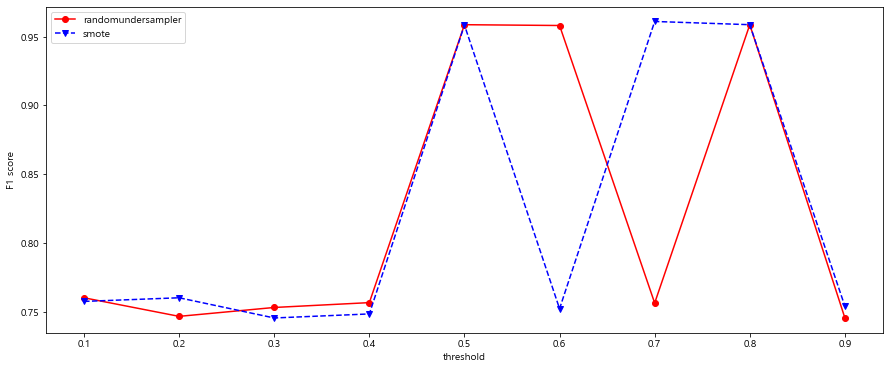

In [26]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, rf_result['F1_score'][:9].to_list(), 'ro-', threshold, rf_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [27]:
idx = []
for i in range(len(rf_result)):
    if rf_result.loc[i]['F1_score'] >= 0.9:
        idx.append(i)

for i in idx:
    print('\n', i, '번째 모델')
    arrange(rf_df[i])


 4 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 163
recall score 실제 충전소가 맞는 지 맞춘 경우 : 145 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47110 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 18 / 47128

 5 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 165
recall score 실제 충전소가 맞는 지 맞춘 경우 : 145 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47108 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 20 / 47128

 7 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 163
recall score 실제 충전소가 맞는 지 맞춘 경우 : 145 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47110 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 18 / 47128

 13 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 158
recall score 실제 충전소가 맞는 지 맞춘 경우 : 142 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47112 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 16 / 47128

 15 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 149
recall score 실제 충전소가 맞는 지 맞춘 경우 : 142 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47121 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 7 / 47128

 16 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 

상위 RandomForest 모델들이 추천한 격자 수 : 22


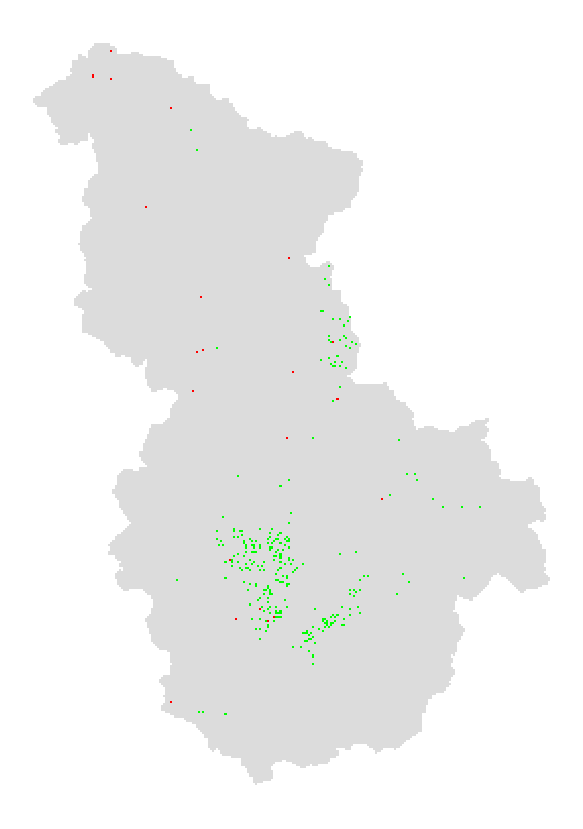

In [28]:
rf_sum = sejong.copy()
rf_sum['FP'] = [0]*len(rf_sum)
for i in idx:
    rf_sum['FP'] += rf_df[i]['FP']
    
print('상위 RandomForest 모델들이 추천한 격자 수 :', len(rf_sum[rf_sum['FP']>0]))

fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
rf_sum[rf_sum['FP']>0].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [29]:
rf_clf[15].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': 841,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 464,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

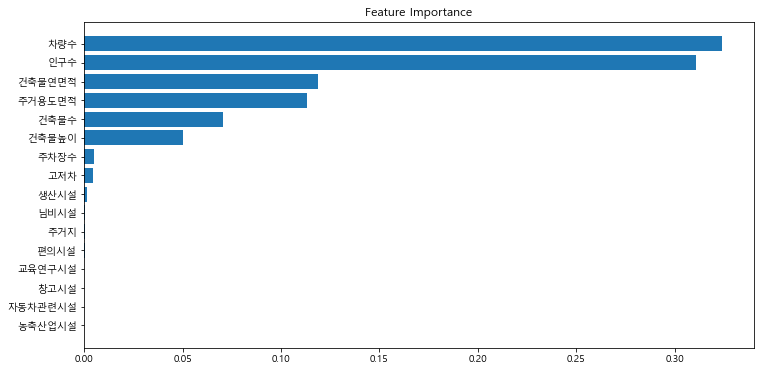

In [30]:
params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': 841,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 464,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

clf = ensemble.RandomForestClassifier(**params)
clf.fit(train_data_rus, train_target_rus)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.7).astype('int')
feature_importance(clf)

### LightGBM

In [45]:
print(lgbm_F1)
print(lgbm_TP)
print(lgbm_FP)
lgbm_result = pd.DataFrame({'F1_score':lgbm_F1,
                            'TP':lgbm_TP,
                            'FP':lgbm_FP})
lgbm_result

[0.6237885462555066, 0.5706314243759177, 0.6575624082232012, 0.6120411160058737, 0.7207048458149778, 0.664610866372981, 0.7444933920704846, 0.7110132158590308, 0.6980910425844347, 0.5139500734214391, 0.517474302496329, 0.49632892804698975, 0.5066079295154186, 0.7873715124816446, 0.47958883994126283, 0.7533039647577092, 0.49691629955947136, 0.7597650513950074]
[224, 228, 218, 223, 232, 229, 238, 239, 232, 225, 230, 230, 228, 208, 237, 214, 225, 213]
[1237, 1422, 1116, 1276, 915, 1103, 840, 955, 992, 1612, 1605, 1677, 1640, 664, 1741, 786, 1670, 763]


F1_score   TP    FP
0   0.623789  224  1237
1   0.570631  228  1422
2   0.657562  218  1116
3   0.612041  223  1276
4   0.720705  232   915
5   0.664611  229  1103
6   0.744493  238   840
7   0.711013  239   955
8   0.698091  232   992
9   0.513950  225  1612
10  0.517474  230  1605
11  0.496329  230  1677
12  0.506608  228  1640
13  0.787372  208   664
14  0.479589  237  1741
15  0.753304  214   786
16  0.496916  225  1670
17  0.759765  213   763

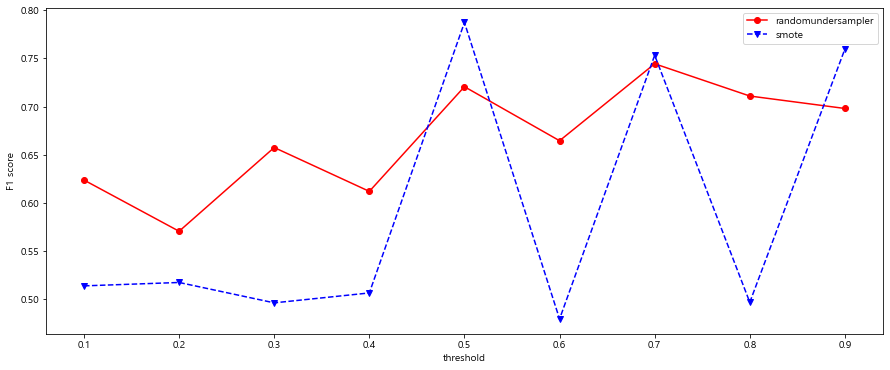

In [46]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, lgbm_result['F1_score'][:9].to_list(), 'ro-', threshold, lgbm_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [47]:
idx = []
for i in range(len(lgbm_result)):
    if lgbm_result.loc[i]['F1_score'] >= 0.9:
        idx.append(i)

for i in idx:
    print('\n', i, '번째 모델')
    arrange(lgbm_df[i])

#### LightGBM은 유의미한 결과가 없음

LightGBM 모델들이 중복 추천한 격자 수 : 0


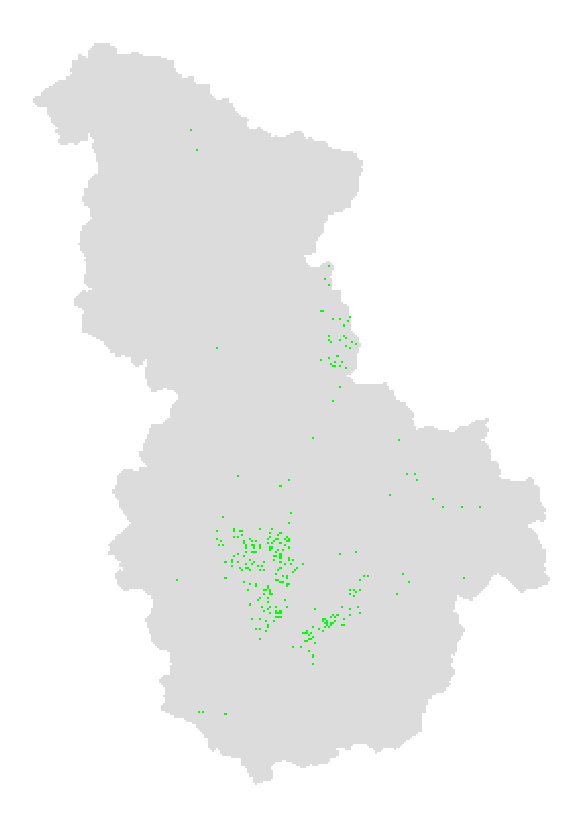

In [49]:
print('LightGBM 모델들이 중복 추천한 격자 수 :', 0)
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
#lgbm_sum[lgbm_sum['FP']>0].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [52]:
lgbm_clf[13].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9381776615907701,
 'importance_type': 'split',
 'learning_rate': 0.00239866828677615,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 3,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.5454110495865738,
 'reg_lambda': 0.5051969110829709,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'colsample_bylevel': 0.6999277944189974,
 'colsample_bynode': 0.8139575126975254,
 'gamma': 0.234823106557617}

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: gamma


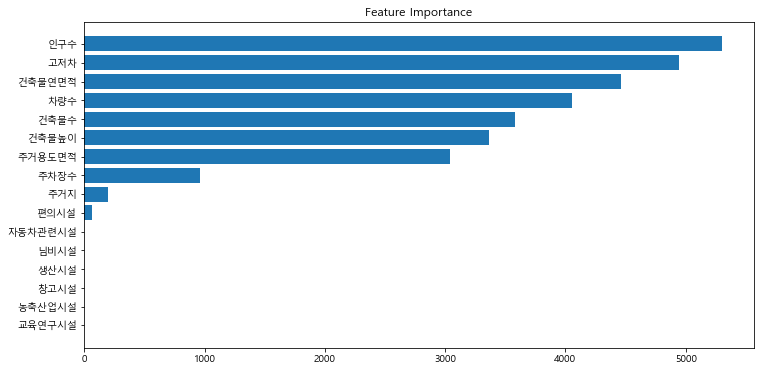

In [50]:
params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9381776615907701,
 'importance_type': 'split',
 'learning_rate': 0.00239866828677615,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 3,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.5454110495865738,
 'reg_lambda': 0.5051969110829709,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'colsample_bylevel': 0.6999277944189974,
 'colsample_bynode': 0.8139575126975254,
 'gamma': 0.234823106557617}

clf = lightgbm.LGBMClassifier(**params)
clf.fit(train_data_rus, train_target_rus, verbose=0)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.5).astype('int')
feature_importance(clf)

## LightGBM은 성능이 낮아 제외

### CatBoost

In [40]:
print(catb_F1)
print(catb_TP)
print(catb_FP)
catb_result = pd.DataFrame({'F1_score':catb_F1,
                            'TP':catb_TP,
                            'FP':catb_FP})
catb_result

[0.7395007342143906, 0.7262848751835536, 0.7295154185022027, 0.9609397944199707, 0.9621145374449339, 0.9594713656387666, 0.9612334801762115, 0.9597650513950073, 0.7274596182085169, 0.7794419970631424, 0.7767988252569751, 0.7841409691629956, 0.8593245227606461, 0.7844346549192364, 0.8461086637298091, 0.7859030837004405, 0.728928046989721, 0.7312775330396476]
[241, 245, 243, 145, 143, 146, 145, 145, 243, 205, 217, 202, 184, 209, 194, 223, 245, 244]
[860, 909, 896, 10, 4, 16, 9, 14, 903, 688, 709, 669, 395, 675, 450, 684, 900, 891]


F1_score   TP   FP
0   0.739501  241  860
1   0.726285  245  909
2   0.729515  243  896
3   0.960940  145   10
4   0.962115  143    4
5   0.959471  146   16
6   0.961233  145    9
7   0.959765  145   14
8   0.727460  243  903
9   0.779442  205  688
10  0.776799  217  709
11  0.784141  202  669
12  0.859325  184  395
13  0.784435  209  675
14  0.846109  194  450
15  0.785903  223  684
16  0.728928  245  900
17  0.731278  244  891

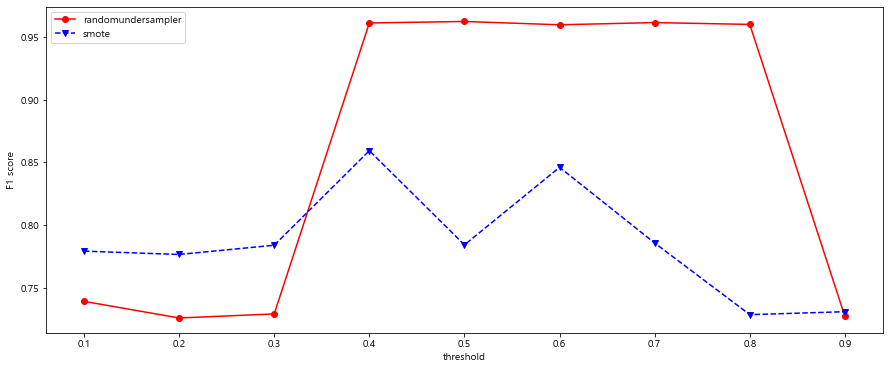

In [41]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, catb_result['F1_score'][:9].to_list(), 'ro-', threshold, catb_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [38]:
idx = []
for i in range(len(catb_result)):
    if catb_result.loc[i]['F1_score'] >= 0.9:
        idx.append(i)

for i in idx:
    print('\n', i, '번째 모델')
    arrange(catb_df[i])

1


상위 catboost 모델들이 추천한 격자 수 : 19


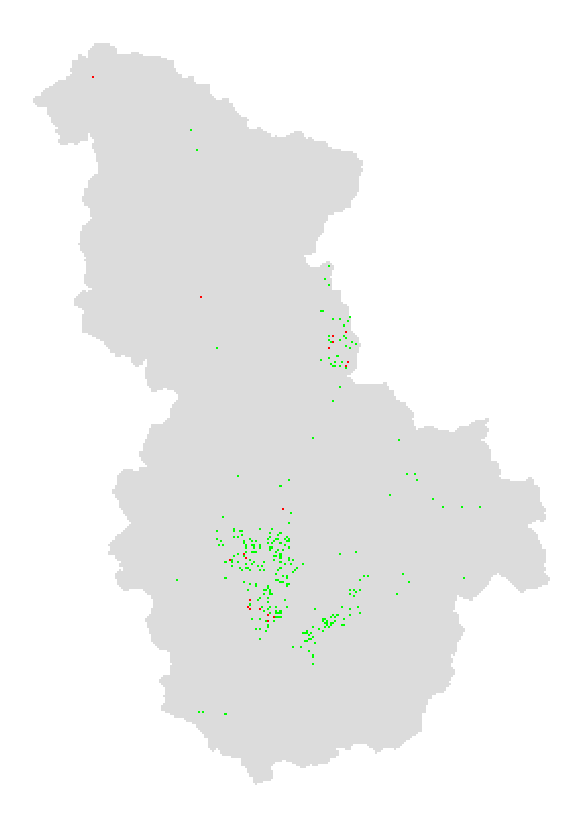

In [43]:
catb_sum = sejong.copy()
catb_sum['FP'] = [0]*len(catb_sum)
for i in idx:
    catb_sum['FP'] += catb_df[i]['FP']

print('상위 catboost 모델들이 추천한 격자 수 :', len(catb_sum[catb_sum['FP']>0]))
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
catb_sum[catb_sum['FP']>0].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [32]:
catb_clf[4].get_params()

{'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'colsample_bylevel': 0.010686539300500302}

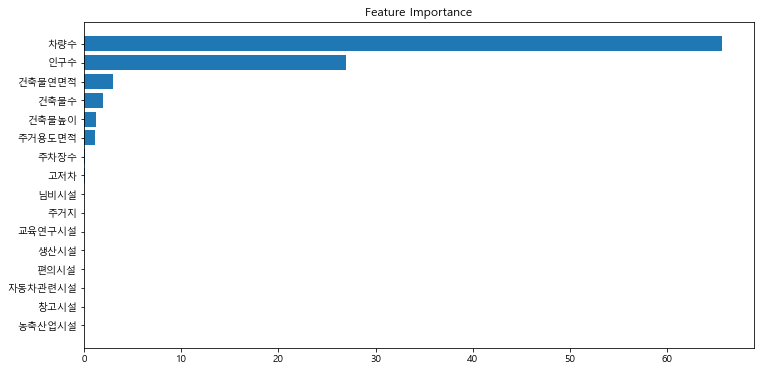

In [33]:
params = {'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'colsample_bylevel': 0.010686539300500302}

clf = catboost.CatBoostClassifier(**params)
clf.fit(train_data_rus, train_target_rus, verbose=0, early_stopping_rounds=100)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.5).astype('int')
feature_importance(clf)

### Deep Learning

In [131]:
print(dl_F1)
print(dl_TP)
print(dl_FP)
dl_result = pd.DataFrame({'F1_score':dl_F1,
                            'TP':dl_TP,
                            'FP':dl_FP})
dl_result

[0.16358296622613802, 0.22936857562408222, 0.5195301027900147, 0.6649045521292217, 0.7183553597650513, 0.7794419970631424, 0.8945668135095448, 0.9565345080763583, 0.9356828193832599, 0.5295154185022026, 0.6851688693098384, 0.6672540381791483, 0.6035242290748899, 0.6816446402349486, 0.7914831130690162, 0.8419970631424377, 0.8602055800293685, 0.9301027900146843]
[266, 267, 252, 238, 236, 178, 168, 145, 144, 247, 238, 237, 245, 231, 202, 186, 181, 155]
[2846, 2623, 1620, 1111, 927, 661, 259, 25, 95, 1581, 1042, 1102, 1327, 1047, 644, 456, 389, 125]


F1_score   TP    FP
0   0.163583  266  2846
1   0.229369  267  2623
2   0.519530  252  1620
3   0.664905  238  1111
4   0.718355  236   927
5   0.779442  178   661
6   0.894567  168   259
7   0.956535  145    25
8   0.935683  144    95
9   0.529515  247  1581
10  0.685169  238  1042
11  0.667254  237  1102
12  0.603524  245  1327
13  0.681645  231  1047
14  0.791483  202   644
15  0.841997  186   456
16  0.860206  181   389
17  0.930103  155   125

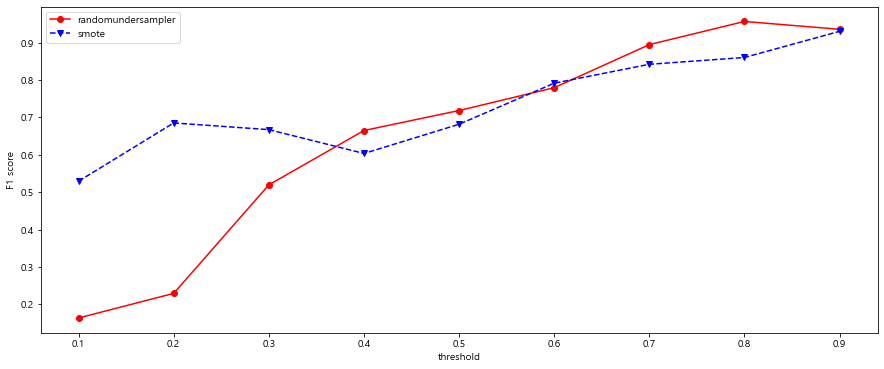

In [106]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(15, 6))
plt.plot(threshold, dl_result['F1_score'][:9].to_list(), 'ro-', threshold, dl_result['F1_score'][9:].to_list(), 'bv--')
plt.legend(['randomundersampler', 'smote'])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.show()

In [132]:
idx = []
for i in range(len(dl_result)):
    if dl_result.loc[i]['F1_score'] >= 0.9:
        idx.append(i)

for i in idx:
    print('\n', i, '번째 모델')
    arrange(dl_df[i])


 7 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 170
recall score 실제 충전소가 맞는 지 맞춘 경우 : 145 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47103 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 25 / 47128

 8 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 239
recall score 실제 충전소가 맞는 지 맞춘 경우 : 144 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47033 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 95 / 47128

 17 번째 모델
실제 충전소 수 : 268
충전소가 있어야 한다고 분류한 타일 수 : 280
recall score 실제 충전소가 맞는 지 맞춘 경우 : 155 / 268
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47003 / 47128
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 125 / 47128


상위 DeepLearning 모델들이 추천한 격자 수 : 24


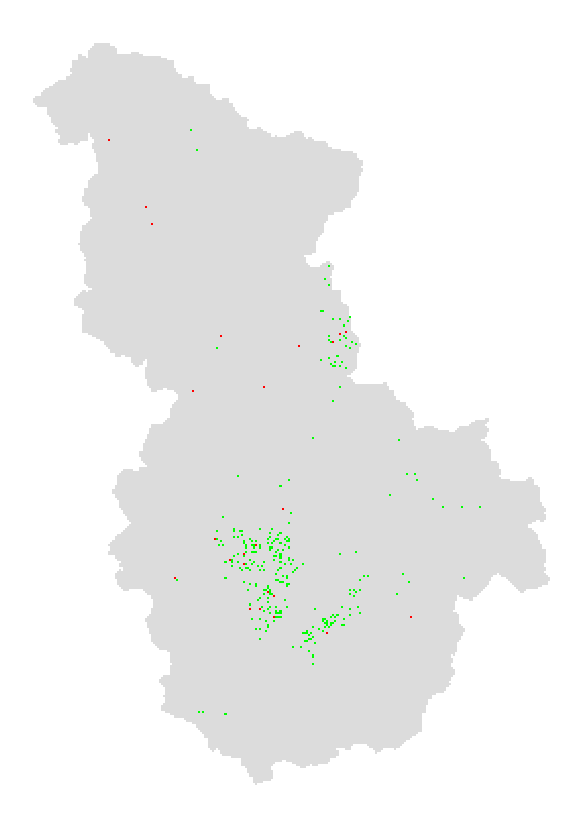

In [133]:
dl_sum = sejong.copy()
dl_sum['FP'] = [0]*len(dl_sum)
for i in idx:
    dl_sum['FP'] += dl_df[i]['FP']
    
print('상위 DeepLearning 모델들이 추천한 격자 수 :', len(dl_sum[dl_sum['FP']>1]))

fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
dl_sum[dl_sum['FP']>1].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [134]:
#dl_sum.to_csv('./dataset/전처리후/deeplearning_result.csv', index=False, encoding='cp949')

### 결과 결합

In [138]:
rf_sum = pd.read_csv('./dataset/전처리후/randomforest_result.csv', encoding='cp949')
#lgbm_sum = pd.read_csv('./dataset/전처리후/lightgbm_result.csv', encoding='cp949') # lgbm은 성능이 낮아 제외
catb_sum = pd.read_csv('./dataset/전처리후/catboost_result.csv', encoding='cp949')
dl_sum = pd.read_csv('./dataset/전처리후/deeplearning_result.csv', encoding='cp949')

In [139]:
idx = rf_sum[rf_sum['FP']>0].index
rf_sum['rf_FP_dup'] = [0]*len(rf_sum)
for i in idx:
    rf_sum['rf_FP_dup'].loc[i] = 1
print(len(rf_sum[rf_sum['rf_FP_dup']==1]))

'''
idx = lgbm_sum[lgbm_sum['FP']>0].index
lgbm_sum['lgbm_FP_dup'] = [0]*len(lgbm_sum)
for i in idx:
    lgbm_sum['lgbm_FP_dup'].loc[i] = 1
print(len(lgbm_sum[lgbm_sum['lgbm_FP_dup']==1]))
'''

idx = catb_sum[catb_sum['FP']>0].index
catb_sum['catb_FP_dup'] = [0]*len(catb_sum)
for i in idx:
    catb_sum['catb_FP_dup'].loc[i] = 1
print(len(catb_sum[catb_sum['catb_FP_dup']==1]))

idx = dl_sum[dl_sum['FP']>1].index
dl_sum['dl_FP_dup'] = [0]*len(dl_sum)
for i in idx:
    dl_sum['dl_FP_dup'].loc[i] = 1
print(len(dl_sum[dl_sum['dl_FP_dup']==1]))

22
19
24


#### 모든 모델이 추천하고 있는 격자를 취합

In [153]:
result = sejong.copy()
result['rf_FP_dup'] = rf_sum['rf_FP_dup']
#result['lgbm_FP_dup'] = lgbm_sum['lgbm_FP_dup']
result['catb_FP_dup'] = catb_sum['catb_FP_dup']
result['dl_FP_dup'] = dl_sum['dl_FP_dup']
result['all_FP_dup'] = rf_sum['rf_FP_dup'] + catb_sum['catb_FP_dup'] + dl_sum['dl_FP_dup']

In [158]:
print('한 개 이상 모델들이 추천한 격자 수 :', len(result[result['all_FP_dup']>=1]))
print('두 개 이상 모델들이 추천한 격자 수 :', len(result[result['all_FP_dup']>=2]))

한 개 이상 모델들이 추천한 격자 수 : 48
두 개 이상 모델들이 추천한 격자 수 : 13


In [155]:
result['1model_select'] = [0] * len(result)

idx = result[result['all_FP_dup']>=1].index
for i in idx:
    result['1model_select'].loc[i] = 1

In [156]:
result['2model_select'] = [0] * len(result)

idx = result[result['all_FP_dup']>=2].index
for i in idx:
    result['2model_select'].loc[i] = 1

### 전기차 충전소 최적 입지 선정 결과

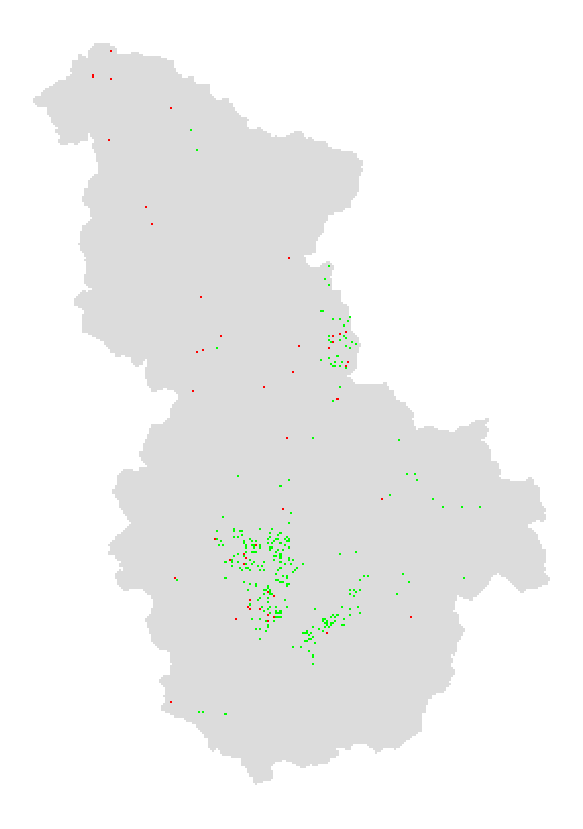

In [161]:
## 한 개 이상의 모델이 선택한 경우 48
map_visualization(result[result.columns[:-1]])

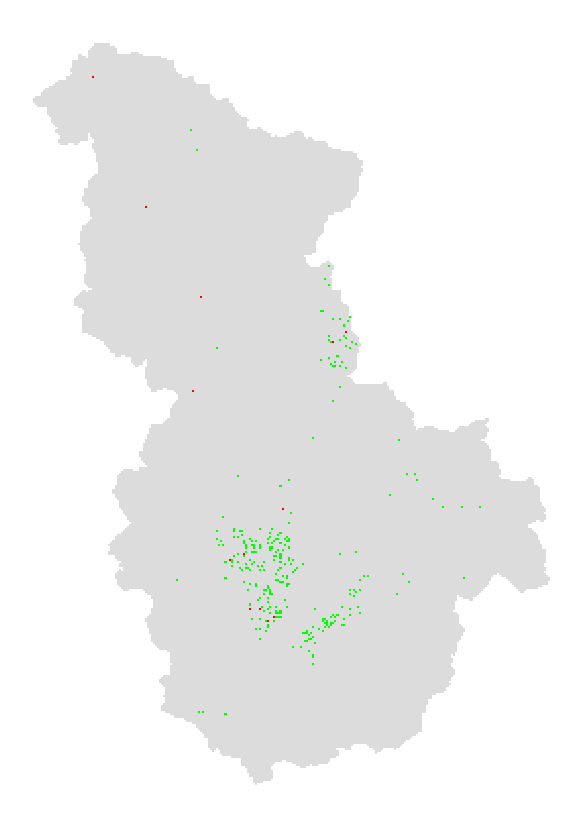

In [162]:
## 두 개 이상의 모델이 선택한 경우 13
map_visualization(result)

In [166]:
result = result[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적',
       '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설', '편의시설',
       '생산시설', '님비시설', '자동차관련시설', 'EV', 'rf_FP_dup', 'catb_FP_dup', 'dl_FP_dup','1model_select', '2model_select']]

result.to_csv('./dataset/전처리후/세종시_전기차_최적입지선정_결과.csv', encoding='cp949')

In [167]:
result = pd.read_csv('./dataset/전처리후/세종시_전기차_최적입지선정_결과.csv', encoding='cp949')

### 지도 시각화

In [63]:
geo = geopandas.read_file('./dataset/전처리전/전국_읍면동_경계.geojson', encoding='utf-8')
geo = geo[geo['sidonm'] == '세종특별자치시']
geo['color'] = [0]*22

In [98]:
m = folium.Map(location=(36.57026017312205, 127.26846706447992), zoom_start=11)
    
heatMap = HeatMap(zip(result['lat'], result['lng'], result['인구수']),
                min_opacity=0.05,
                max_val=5,
                radius=5, blur=3,
                max_zoom=10,color='red')

m.add_child(heatMap)
#m.save('heatmap_세종_인구수.html')
m

### 기존 충전소 위치

In [91]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map

mc = MarkerCluster()
for i in result[result['EV']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']])
    )
    
m.add_child(mc)

# Display the map
m
#m.save('./시각화/현재_설치된_충전소_위치.html')

### 모델별 입지 시각화

In [170]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map

mc = MarkerCluster()
for i in result[result['dl_FP_dup']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']])
    )
    
m.add_child(mc)

# Display the map
m
#m.save('./시각화/DeepLearning_결과.html')

### 최적 입지 마커클러스터

In [173]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map
mc = MarkerCluster()
for i in result[result['2model_select']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='blue', icon='thumbs-up', prefix='fa'))
    )
    
m.add_child(mc)
# Display the map
m
#m.save('./시각화/최적입지결과.html')

### 최적 입지와 현재 충전소 위치 비교

In [176]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map
mc = MarkerCluster()
for i in result[result['2model_select']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='blue', icon='thumbs-up', prefix='fa'))
    )
    
m.add_child(mc)

mc = MarkerCluster()
for i in result[result['EV']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='red', icon='flash', prefix='fa'))
    )
    
m.add_child(mc)

# Display the map
m
#m.save('./시각화/현_충전소와_최적입지_비교.html')

### Pydeck 3D 시각화

#### 정규화 및 좌표계 변경

In [75]:
sejong_pydeck = sejong[sejong['인구수']<=1000].copy()
sejong_pydeck_minmax = scaler.fit_transform(sejong[['인구수']])
sejong_pydeck_minmax = pd.DataFrame(sejong_pydeck_minmax, columns=['인구수'])
sejong_pydeck['인구수정규화'] = sejong_pydeck_minmax

In [76]:
geometry = sejong_pydeck['geometry'].astype(str)

length_100m = (36.73376199366808 - 36.40675835257603) / 364
width_100m = (127.4092754044858 - 127.12765872447403) / 254

co = []

for g in geometry:
    temp1 = []
    for t in g.split('((')[1].split('))')[0].split(', '):
        temp2 = []
        temp2.append((int(t.split()[0]) - 966700) / 100 * width_100m + 127.12765872447403)
        temp2.append((int(t.split()[1]) - 1823200) / 100 * length_100m + 36.40675835257603)
        temp1.append(temp2)
    co.append(temp1)

sejong_pydeck['coordinates'] = co

#### pydeck params

In [77]:
view_state = pydeck.ViewState(
    latitude=36.57026017312205,
    longitude=127.26846706447992,
    zoom=11,
    max_zoom=20,
    pitch=45,
    bearing=0)

In [78]:
layer = pydeck.Layer(
    'PolygonLayer',
    sejong_pydeck[sejong_pydeck['인구수정규화']>0],
    get_polygon='coordinates',
    #get_position='[lng, lat]',
    auto_highlight=True,
    elevation_scale=5000,
    #elevation_range=[0, 3000],
    pickable=True,
    #get_fill_color='[0, 255*인구수정규화, 0]',
    get_fill_color='[200, 100, 150, 140]',
    extruded = True,
    get_elevation = '인구수정규화',
)

In [82]:
r = pydeck.Deck(
    map_style='light',
    layers=layer,
    initial_view_state=view_state)

r
#r.to_html('./시각화/pydeck_인구수.html')

### column corr heatmap 상관관계 시각화

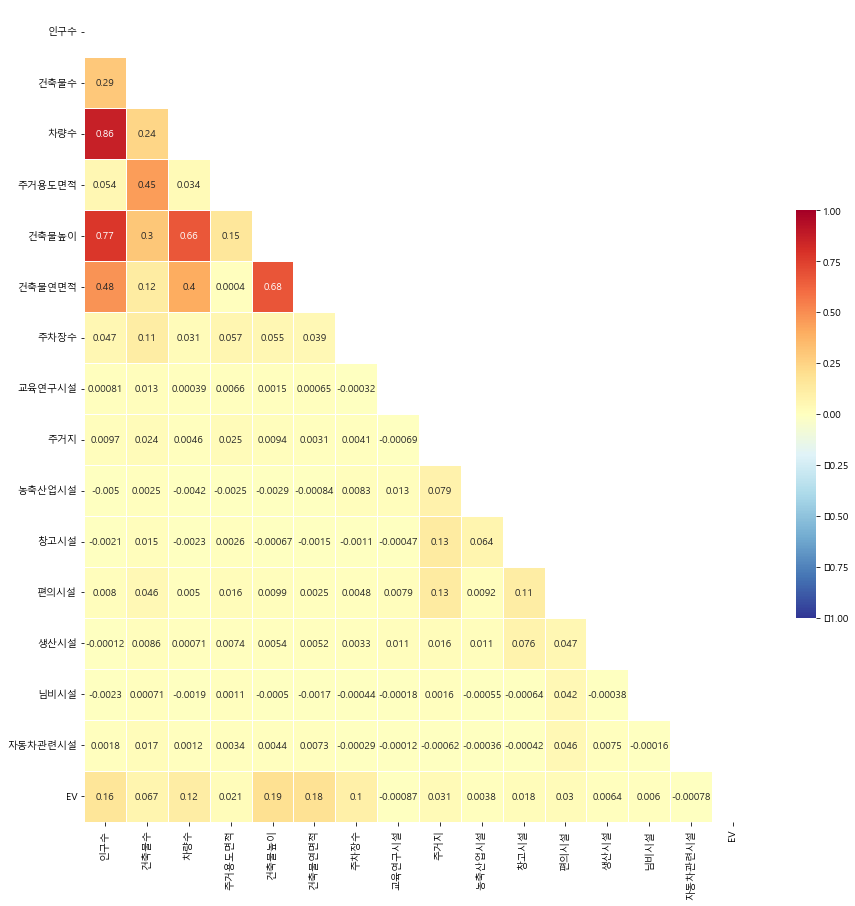

In [80]:
df = sejong[sejong.columns[3:]].corr()

fig, ax = plt.subplots( figsize=(15,15) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

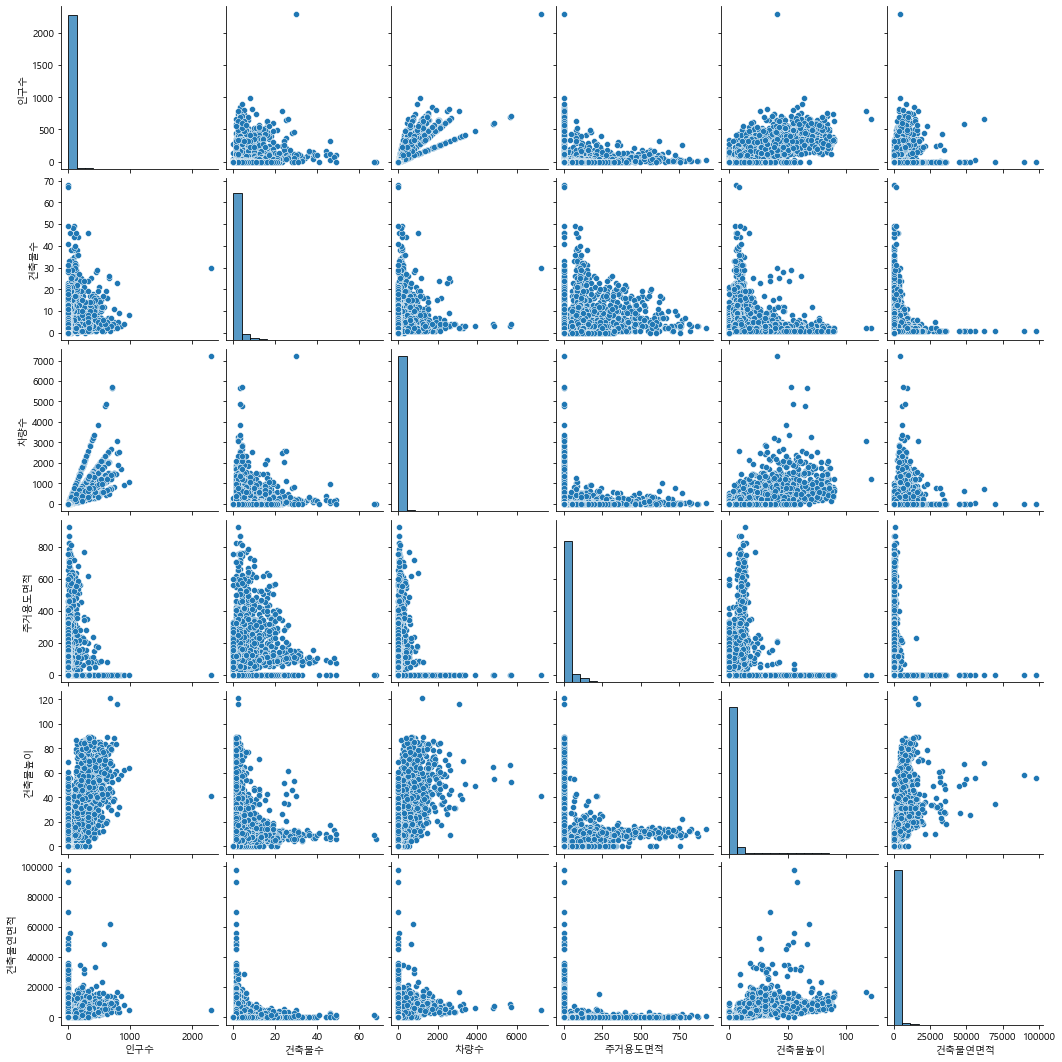

In [81]:
sns.pairplot(sejong[sejong.columns[3:10]])
plt.show()